# A/B测试（A/B Testing）
是一种通过对比两个或多个版本（如网页、功能、广告等）的效果，确定哪个版本更优的实验方法。其核心原理是随机分组和假设检验，通过统计学方法验证差异是否显著。

## 导入数据

In [64]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.stats.api as sms


# 设置中文字体为 SimHei，并解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

In [2]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
# 执行操作后恢复警告
warnings.filterwarnings('default')

In [3]:
#导入数据
df = pd.read_csv('ab_data.csv')

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


user_id:用户ID  
timestamp:用户访问页面时间  
group:用户分组情况【treatment-新；control-旧】  
landing_page: 分到的页面，与group字段一一对应  
converted:是否成功转化

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df.columns.tolist()


['user_id', 'timestamp', 'group', 'landing_page', 'converted']

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [40]:
df.groupby('group').describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788053.5  867155.50  945998.0  147202.0  0.120399  0.325429  0.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  0.323695  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

In [8]:
df.duplicated().sum()

0

In [9]:
#查看分组情况
df['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

## 数据清洗

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
#检查用户id的重复情况
df['user_id'].duplicated().sum()

3894

In [13]:
#查看重复用户id
del_id = df[df['user_id'].duplicated()]['user_id'].values
del_id

array([698120, 773192, 899953, ..., 641570, 689637, 744456], dtype=int64)

In [14]:
df[df['user_id'] == 698120]

,user_id,timestamp,group,landing_page,converted
988,698120,2017-01-22 07:09:37.540970,control,new_page,0
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0


In [15]:
#删除id值重复的数据
df_new = df[~df['user_id'].isin(del_id)]
df_new['user_id'].duplicated().sum()

0

In [16]:
#处理时间字段
df_new.loc[:,'timestamp']=pd.to_datetime(df_new['timestamp'],format = '%Y-%m-%d %H:%M:%S.%f' ).dt.strftime('%Y-%m-%d')
df_new.dtypes


user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [17]:
df_new.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [18]:
#查看日期跨度，实验周期，避免因周末特殊情况对实验造成影响
df_new['timestamp'].value_counts()


timestamp
2017-01-08    13231
2017-01-10    13184
2017-01-11    13183
2017-01-06    13168
2017-01-23    13164
2017-01-21    13139
2017-01-15    13081
2017-01-09    13064
2017-01-22    13059
2017-01-20    13051
2017-01-03    13025
2017-01-07    13013
2017-01-12    12992
2017-01-14    12983
2017-01-17    12976
2017-01-19    12968
2017-01-16    12948
2017-01-04    12929
2017-01-18    12915
2017-01-13    12893
2017-01-05    12748
2017-01-24     7345
2017-01-02     5631
Name: count, dtype: int64

In [43]:
print("实验持续天数",len(df_new['timestamp'].unique()))
print(f"实验周期：{df_new['timestamp'].min()}~{df_new['timestamp'].max()}")

实验持续天数 23
实验周期：2017-01-02~2017-01-24


In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


In [21]:
#group:用户分组情况【treatment-新；control-旧】
#landing_page: 分到的页面，与group字段一一对应
#利用crosstab交叉表检查对应情况
pd.crosstab(df_new['group'],df_new['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## 假设检验

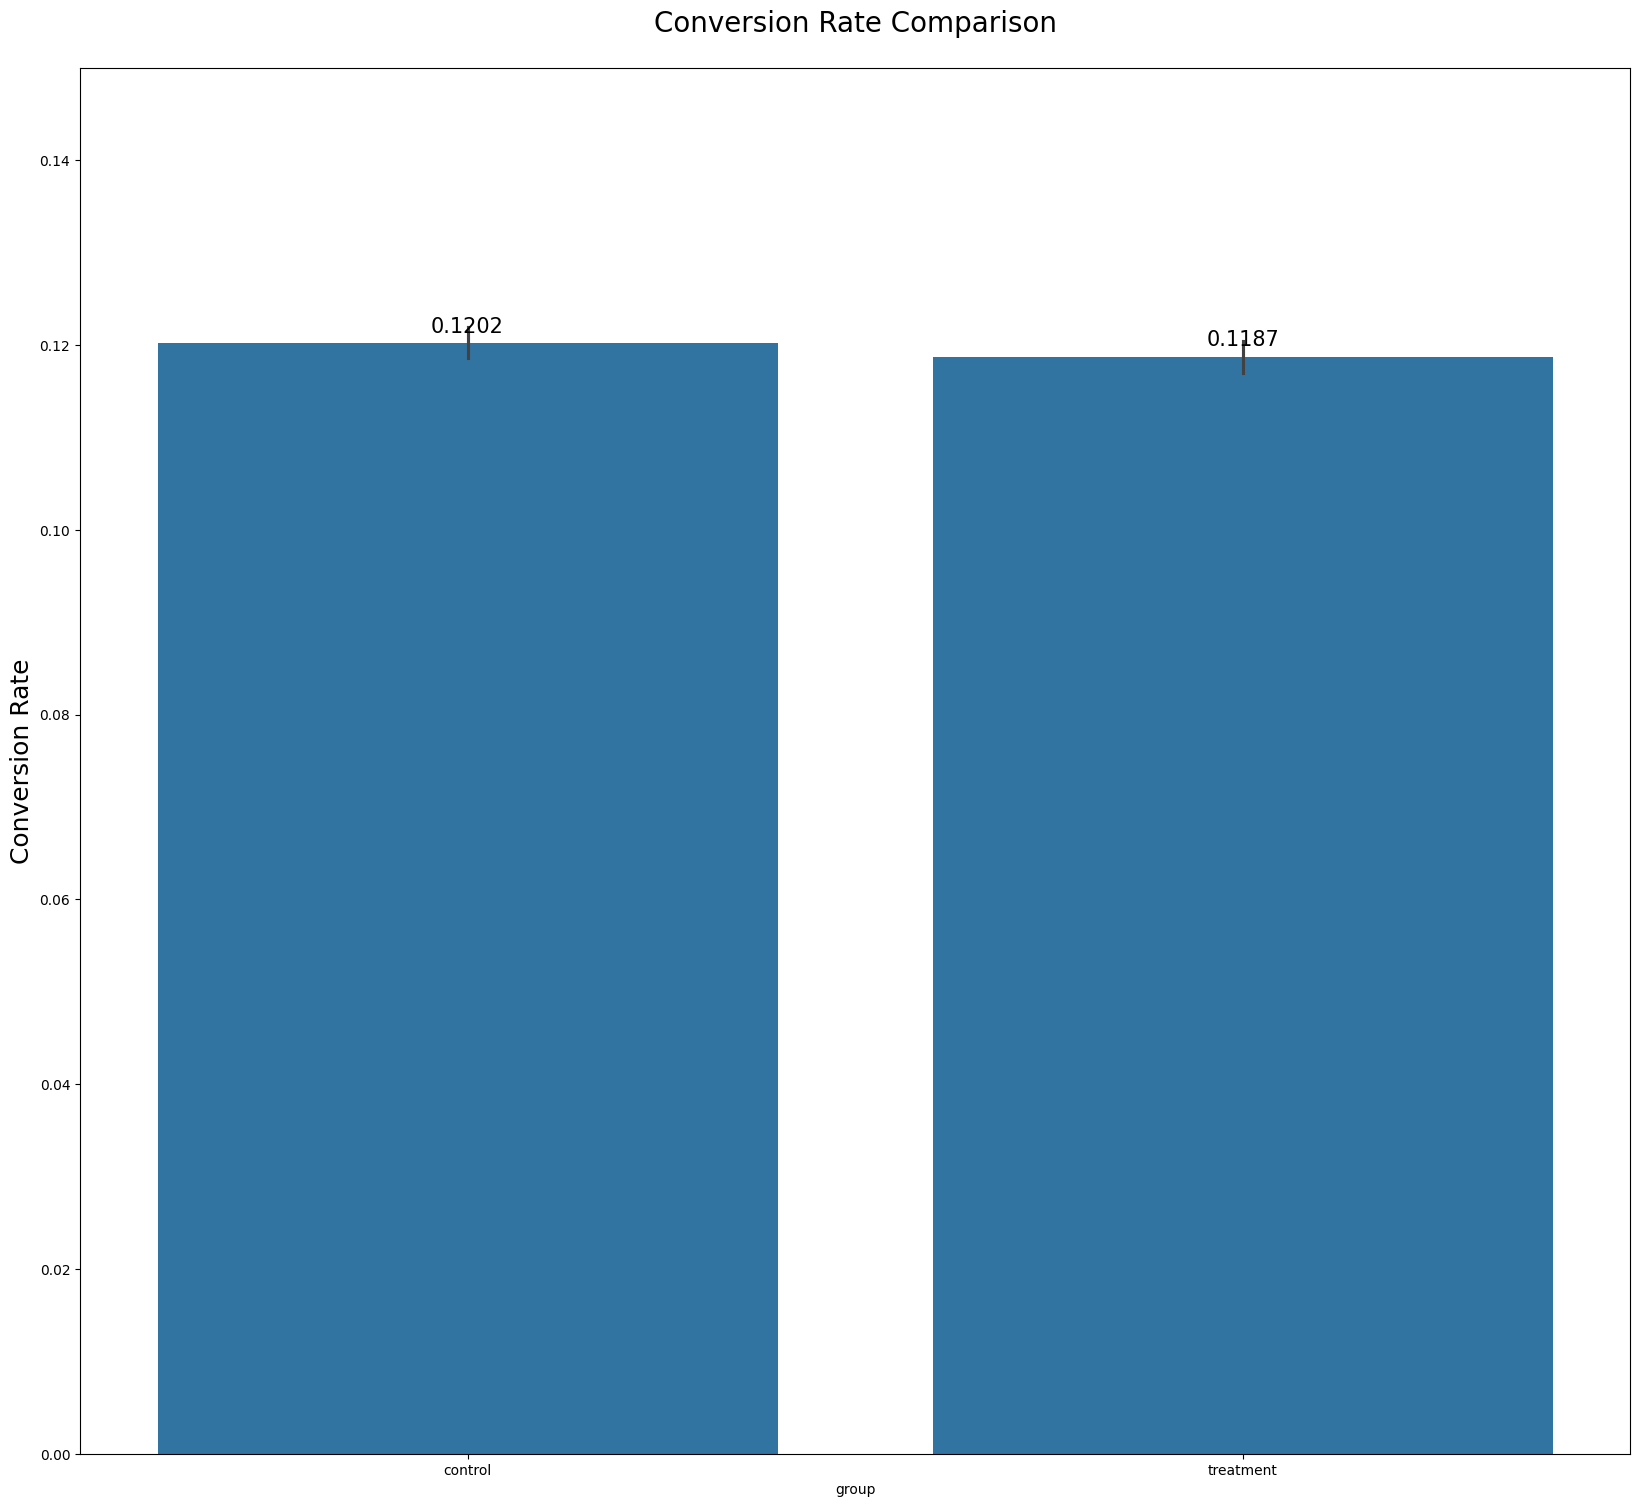

In [58]:
#查看总体转化率情况
plt.figure(figsize = (20,18))
#条形图绘制
ax  = sns.barplot(x = 'group',y = 'converted',data = df_new,estimator=np.mean,errorbar=('ci', 95))
for container in ax.containers:
    ax.bar_label(container,fmt='%.4f',padding=5,label_type='edge',fontsize=15,color='black')
plt.title('Conversion Rate Comparison',y =1.02,fontsize=20)
plt.ylabel('Conversion Rate',fontsize = 18)
plt.ylim(0, 0.15) #控制y轴上下限
plt.show()

In [50]:
#df.sample()随机抽样分组，每组5000样本，为复现结果，random_state = 42
required_n = 5000
seed = 42

control_sample = df_new[df_new['group'] == 'control'].sample(n = required_n,random_state=seed)
treatment_sample = df_new[df_new['group'] == 'treatment'].sample(n = required_n,random_state=seed)

#concat（）拼接俩组数据
ab_test = pd.concat([control_sample,treatment_sample],axis = 0)
display(ab_test.head(),ab_test.tail())

,user_id,timestamp,group,landing_page,converted
293433,663037,2017-01-05,control,old_page,0
260295,932826,2017-01-13,control,old_page,1
288076,922999,2017-01-04,control,old_page,0
232006,857826,2017-01-19,control,old_page,0
183256,762926,2017-01-18,control,old_page,0


,user_id,timestamp,group,landing_page,converted
113807,656399,2017-01-13,treatment,new_page,0
155767,945314,2017-01-19,treatment,new_page,0
237344,805783,2017-01-12,treatment,new_page,0
128315,632288,2017-01-16,treatment,new_page,0
271383,868046,2017-01-11,treatment,new_page,0


In [24]:
#reset_index()重置索引
ab_test.reset_index(inplace=True,drop = True)
display(ab_test.head(),ab_test.tail())

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05,control,old_page,0
1,932826,2017-01-13,control,old_page,1
2,922999,2017-01-04,control,old_page,0
3,857826,2017-01-19,control,old_page,0
4,762926,2017-01-18,control,old_page,0


,user_id,timestamp,group,landing_page,converted
9995,656399,2017-01-13,treatment,new_page,0
9996,945314,2017-01-19,treatment,new_page,0
9997,805783,2017-01-12,treatment,new_page,0
9998,632288,2017-01-16,treatment,new_page,0
9999,868046,2017-01-11,treatment,new_page,0


In [25]:
#利用pd.crosstab()交叉表检验数据，确保control组全为old_page,treament组全为new_page
pd.crosstab(ab_test['group'],ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,5000
treatment,5000,0


In [26]:
#计算A/B测试中实验组和对照组的转化率CVR（conversion_rate）及其标准差
c_r = ab_test.groupby('group')['converted'].agg([pd.Series.mean,pd.Series.std])
c_r.columns = ['conversion_rate','std_deviation']
c_r

,conversion_rate,std_deviation
group,,
control,0.1164,0.320736
treatment,0.1288,0.335012


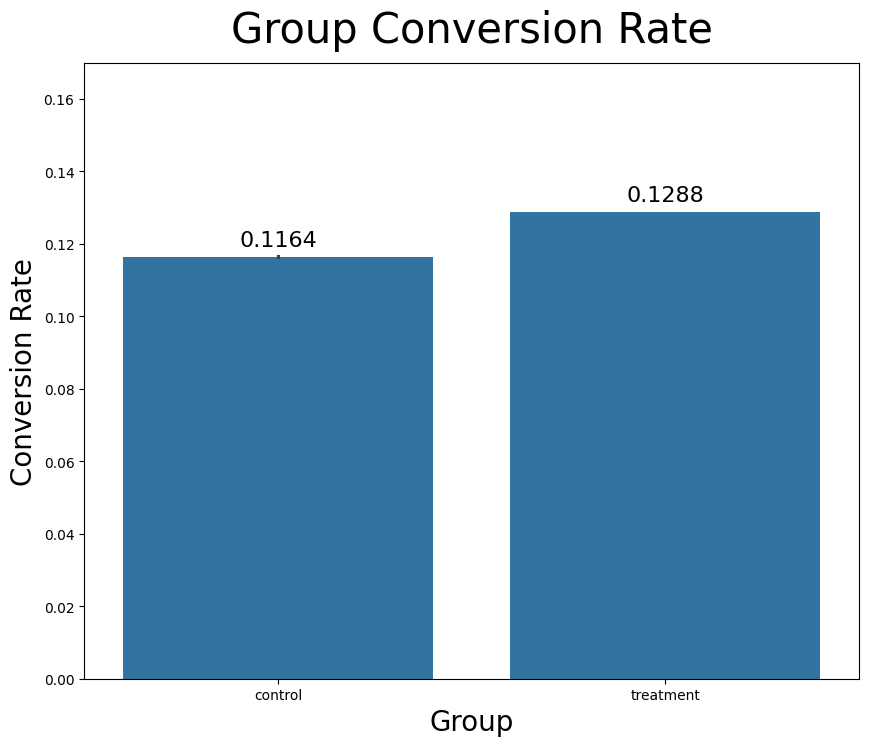

实验组treatment的转化率高出基础组control的转化率的百分比为：10.65%


In [60]:
#CVR可视化
# plt.rcParams['font.family'] = 'SimHei'
# plt.rcParams['axes.unicode_minus'] = False

# plt.figure(figsize = (10,8),dpi = 100)
# sns.barplot(x = 'group',y = 'converted',data = ab_test,errorbar=('ci',True)) #ci：Confidence Interval（置信区间）

# plt.ylim(0, 0.17)
# plt.title('Group conversion rate', fontsize=30,y = 1.02)
# plt.xlabel('Group', fontsize=20)
# plt.ylabel('conversion rate', fontsize=20)

plt.figure(figsize=(10, 8), dpi=100)
ax = sns.barplot(x='group', y='converted', data=ab_test, errorbar=('ci', True))

# 在每个柱子上方添加数值标签（格式化为百分比）
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', label_type='edge', padding=5, 
                 fontsize=16, color='black')  # 将小数转换为百分比

plt.ylim(0, 0.17)
plt.title('Group Conversion Rate', fontsize=30, y=1.02)
plt.xlabel('Group', fontsize=20)
plt.ylabel('Conversion Rate', fontsize=20)
plt.show()

#计算实验组treatment的转化率高出基础组control的转化率的百分比
cr_up_ratio =(ab_test[ab_test['group'] == 'treatment']['converted'].mean() - ab_test[ab_test['group'] == 'control']['converted'].mean())/ ab_test[ab_test['group'] == 'control']['converted'].mean()
print('实验组treatment的转化率高出基础组control的转化率的百分比为：{:.2%}'.format(cr_up_ratio))


高出10.65%是否显著——假设检验（z检验，t检验）  
总体方差已知：z检验  
总体方差未知：  
    样本容量大：z检验  
    样本容量小：t检验，

In [28]:
#导入z检验所需包 confint：confidence interval置信区间
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

In [61]:
#提取结果
c_results = ab_test[ab_test['group'] == 'control']['converted']
t_results = ab_test[ab_test['group'] == 'treatment']['converted']

#计算观测值数量nobs observations
n_c = c_results.count()
n_t = t_results.count()
#成功转化数量
successes = [c_results.sum(),t_results.sum()]
nobs = [n_c,n_t]
nobs,successes

([5000, 5000], [582, 644])

In [30]:
#z检验
#计算得到z值和p值（z_stat：Z统计量，衡量两组差异的标准化距离。pval：P值，表示观察到的差异由随机性导致的概率）
z_stat,pval = proportions_ztest(successes,nobs = nobs)

#分别计算俩组转化率的置信区间，置信水平alpha【95%】
(lower_c,lower_t),(upper_c,upper_t) = proportion_confint(successes,nobs = nobs,alpha=0.95,method = 'beta')
print(f'z_stat:{z_stat:.2f}')
print(f'p:{pval:.2f}')
print(f'95% for control:[{lower_c:.3f},{upper_c:.3f}]')
print(f'95% for treatment:[{lower_t:.3f},{upper_t:.3f}]')

z_stat:-1.89
p:0.06
95% for control:[0.116,0.117]
95% for treatment:[0.128,0.129]


p = 0.06 > 0.05高于显著性水平，从而不能拒绝原假设，即认为实验组与对照组无明显差异  
  且实验组treatment的置信区间[0.129,0.129]不包含预期的15%，同样说明新方案无法达到预期。

# 拓展：多种统计检验方法  
设预期转化率为12%

In [31]:
df_new.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [32]:
# 探索性分析
len(df_new[df_new['group'] == 'control']),len(df_new[df_new['group'] == 'treatment'])

(143293, 143397)

In [ ]:
"""
想象你是一个机场安检员，任务是检测旅客是否携带违禁品：

原假设（H₀）：旅客没有违禁品
备择假设（H₁）：旅客携带违禁品

统计功效就是：当旅客真的携带违禁品时，你成功检测到的概率。
若你的安检仪功效=0.8，意味着100个带违禁品的旅客中，你能抓住80个，漏掉20个（即20%的漏检率）。

在A/B测试中的具体定义
power：统计功效 = 1 - β（β是第二类错误概率，去真存伪）

含义：当两组真实存在差异时，实验能正确检测到差异的概率。

常见设置：power=0.8（即80%概率发现真实差异）


"""
#确定样本大小
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

#参数设置(基线转化率10%，检测2%绝对提升，相对提升20%)
alpha = 0.05    #显著性水平（置信区间为95%）
power = 0.8     #统计功效（80%概率发现真实差异）
p1 = 0.10       #基线转化率（control对照组）
p2 = 0.12      #预期转化率（treatment实验组）
ratio = 1       #实验组对照组比例

#计算效应量
effect_size = proportion_effectsize(p1,p2)

#计算每组样本量
analysis = NormalIndPower()
n_per_sample = analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio = ratio
)
print(f"每组需要样本量：{n_per_sample:.0f}")

每组需要样本量：3835


In [34]:
#数据抽样，总体近30w，抽样每组5000人（全局test耗时耗力）
control_test = df_new[df_new['group'] == 'control'].sample(n=5000,random_state=42)
treatment_test = df_new[df_new['group'] == 'treatment'].sample(n=5000,random_state = 42)

#每组成功转化率
c_num = control_test[control_test['converted'] == 1]['converted'].count()
t_num = treatment_test[treatment_test['converted'] == 1]['converted'].count()

#每组数量
c_total = control_test['converted'].count()
t_total = treatment_test['converted'].count()


### Z检验

In [35]:
#Z检验
z_stats1,p_val1 = proportions_ztest([c_num,t_num],nobs=[c_total,t_total])
#计算置信区间
(lower_c,lower_t),(upper_c,upper_t) = proportion_confint([c_num,t_num],nobs = [c_total,t_total],alpha=0.95,method = 'beta')


### 卡方检验

In [62]:
#创建联立表
contingency_table = np.array([
    [c_num,c_total - c_num],
    [t_num,t_total - t_num]
])
display(contingency_table)
"""
chi2_stat：卡方统计量，衡量观察值与期望值之间的偏离程度。值越大，说明实际观测值与原假设下的期望值差异越大。
chi2_p：p 值，表示在原假设成立的情况下，观察到当前或更极端结果的概率。通常与 0.05 比较，小于 0.05 表示拒绝原假设（两组转化率存在显著差异）。
dof：自由度，计算方式为(行数-1)×(列数-1)，这里是(2-1)×(2-1)=1。
expected：在原假设（两组无差异）下的期望频数表。
"""
chi2_stat,chi_p,dof,expected = stats.chi2_contingency(contingency_table)

array([[ 582, 4418],
       [ 644, 4356]], dtype=int64)

### Fisher精确性检验
适用于小样本检验

In [37]:
"""
odds_ratio：优势比，表示实验组相对于对照组的优势程度。OR>1 表示实验组更优，OR<1 表示对照组更优。
fisher_p：p 值，与卡方检验类似，但 Fisher 检验在小样本下更精确。
"""
odds_ratio,fisher_p = stats.fisher_exact(contingency_table)

### 贝叶斯分析


实验组转化率高于对照组的概率: 97.22%
预期相对提升: 10.81%
95%可信区间: [-0.29%, 22.68%]


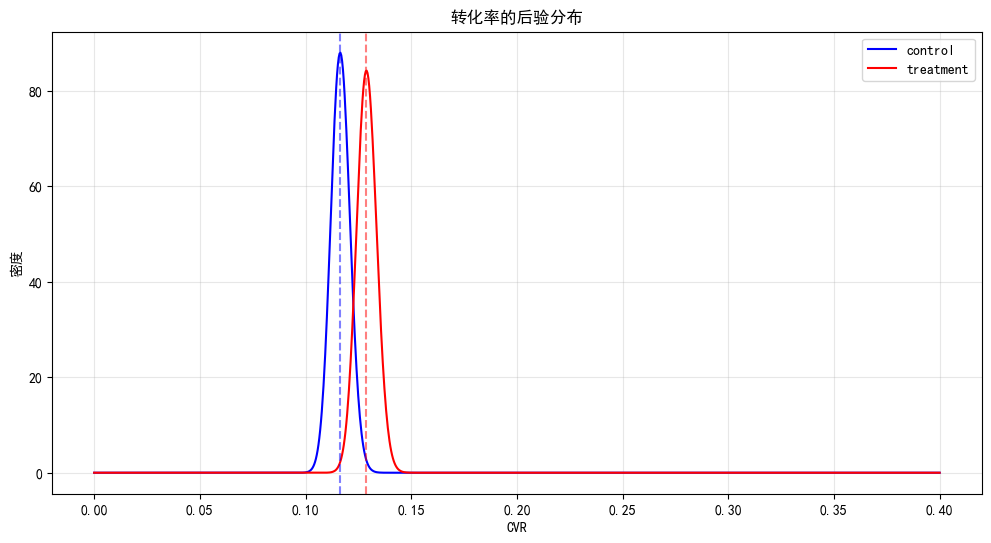

In [65]:
# from bayes import beta_proportion  # pip install bayesian-tests
# beta_result = beta_proportion(c_num,c_total,t_num,t_total)

# 贝叶斯分析 (使用Beta分布)
# 设置先验 (无信息先验 Beta(1,1))
a_prior, b_prior = 1, 1

# 计算后验分布参数
a_post_control = c_num + a_prior
b_post_control = c_total - c_num + b_prior
a_post_treatment = t_num + a_prior
b_post_treatment = t_total - t_num + b_prior

# 采样计算概率
samples = 5000
control_samples = stats.beta.rvs(a_post_control, b_post_control, size=samples)
treatment_samples = stats.beta.rvs(a_post_treatment, b_post_treatment, size=samples)

# 计算实验组优于对照组的概率
prob_better = np.mean(treatment_samples > control_samples)

# 计算相对提升
relative_improvement = (treatment_samples / control_samples - 1) * 100  # 转换为百分比
expected_relative_improvement = np.mean(relative_improvement)
credible_interval = np.percentile(relative_improvement, [2.5, 97.5])

# 输出结果
print(f"实验组转化率高于对照组的概率: {prob_better:.2%}")
print(f"预期相对提升: {expected_relative_improvement:.2f}%")
print(f"95%可信区间: [{credible_interval[0]:.2f}%, {credible_interval[1]:.2f}%]")

# 可视化后验分布
plt.figure(figsize=(12, 6))
x = np.linspace(0, 0.4, 1000)
plt.plot(x, stats.beta.pdf(x, a_post_control, b_post_control), 'b-', label='control')
plt.plot(x, stats.beta.pdf(x, a_post_treatment, b_post_treatment), 'r-', label='treatment')
plt.axvline(c_num/c_total, color='blue', linestyle='--', alpha=0.5)
plt.axvline(t_num/t_total, color='red', linestyle='--', alpha=0.5)
plt.title('转化率的后验分布')
plt.xlabel('CVR')
plt.ylabel('密度')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 结果分析

In [39]:
# 计算转化率
c_rate = c_num / c_total
t_rate = t_num / t_total
rate_diff = t_rate - c_rate

# 输出结果
print("=== 基础数据 ===")
print(f"对照组: 转化数={c_num}, 样本量={c_total}, 转化率={c_rate:.4%}")
print(f"实验组: 转化数={t_num}, 样本量={t_total}, 转化率={t_rate:.4%}")
print(f"转化率差值: {rate_diff:.4%}")

print("\n=== Z检验结果 ===")
print(f"Z统计量: {z_stats1:.4f}")
print(f"p值: {p_val1:.4f}")
print(f"对照组95%置信区间: [{lower_c:.4%}, {upper_c:.4%}]")
print(f"实验组95%置信区间: [{lower_t:.4%}, {upper_t:.4%}]")

print("\n=== 卡方检验结果 ===")
print(f"卡方统计量: {chi2_stat:.4f}")
print(f"p值: {chi_p:.4f}")
print(f"自由度: {dof}")
print("期望频数表:")
print(expected)

print("\n=== Fisher精确检验结果 ===")
print(f"优势比: {odds_ratio:.4f}")
print(f"p值: {fisher_p:.4f}")

# 分析结论
alpha = 0.05
print("\n=== 分析结论 ===")
if p_val1 < alpha and chi_p < alpha and fisher_p < alpha:
    print("根据Z检验、卡方检验和Fisher精确检验的结果，p值均小于0.05，")
    print("可以拒绝原假设，认为实验组和对照组之间存在显著差异。")
    if t_rate > c_rate:
        print(f"实验组转化率({t_rate:.4%})显著高于对照组({c_rate:.4%})，建议采用实验组方案。")
    else:
        print(f"对照组转化率({c_rate:.4%})显著高于实验组({t_rate:.4%})，建议继续使用对照组方案。")
else:
    print("根据Z检验、卡方检验和Fisher精确检验的结果，p值均大于0.05，")
    print("无法拒绝原假设，认为实验组和对照组之间没有显著差异。")
    print(f"虽然观察到实验组转化率为{t_rate:.4%}，对照组为{c_rate:.4%}，")
    print("但这种差异可能是由随机因素引起的。")

=== 基础数据 ===
对照组: 转化数=582, 样本量=5000, 转化率=11.6400%
实验组: 转化数=644, 样本量=5000, 转化率=12.8800%
转化率差值: 1.2400%

=== Z检验结果 ===
Z统计量: -1.8904
p值: 0.0587
对照组95%置信区间: [11.6041%, 11.6810%]
实验组95%置信区间: [12.8428%, 12.9222%]

=== 卡方检验结果 ===
卡方统计量: 3.4592
p值: 0.0629
自由度: 1
期望频数表:
[[ 613. 4387.]
 [ 613. 4387.]]

=== Fisher精确检验结果 ===
优势比: 0.8910
p值: 0.0629

=== 分析结论 ===
根据Z检验、卡方检验和Fisher精确检验的结果，p值均大于0.05，
无法拒绝原假设，认为实验组和对照组之间没有显著差异。
虽然观察到实验组转化率为12.8800%，对照组为11.6400%，
但这种差异可能是由随机因素引起的。
